In [37]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
import sympy as sym

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18

from scipy.optimize import curve_fit

# IMPORT CUSTOM LIBRARIES
from IN8_read_data import gen_data_df_specJun24, load_mus
from functions import *
from alias import *

In [38]:
data = gen_data_df_specJun24('./data/scan_database.tsv', './data/rawdata/')

MSdata = {}
for T in [160, 200, 300]:
    MSdata[T] = pd.read_csv('./data/MSdata/simdata/simdata_'+str(T)+'K.csv')

MU = load_mus()

Qs = [.5, .7, .9, 1.1, 1.5]

## Load experimental parameters
The starting point is the definition of the experimental parameters.

In [39]:
############ Experimental parameters############
kf = 5.8 # Angstrom^-1
Ef = k2E(kf)
kf_HR = 4.9 # Angstrom^-1
Ef_HR = k2E(kf_HR)
r1_vanadium = 1 # mm, vanadium thickness
r2_vanadium = 1.2 # mm, vanadium thickness
r1_sample = 1 # mm, sample thickness
r2_sample = 1.2 # mm, sample thickness

from resolution import FWHM, FWHM_HR
################################################

print('kf =', kf, 'Angstrom^-1')
print('Ef =', Ef, 'meV\n')
print('kf_HR =', kf_HR, 'Angstrom^-1')
print('Ef_HR =', Ef_HR, 'meV\n')

print('Cell specifications:')
print('r1_vanadium =', r1_vanadium, 'cm')
print('r2_vanadium =', r2_vanadium, 'cm')
print('r1_sample =', r1_sample, 'cm')
print('r2_sample =', r2_sample, 'cm\n')

print('Resolution:')
print('FWHM =', FWHM, 'meV')
print('FWHM_HR =', FWHM_HR, 'meV\n')

kf = 5.8 Angstrom^-1
Ef = 69.70269243254256 meV

kf_HR = 4.9 Angstrom^-1
Ef_HR = 49.74915711371425 meV

Cell specifications:
r1_vanadium = 1 cm
r2_vanadium = 1.2 cm
r1_sample = 1 cm
r2_sample = 1.2 cm

Resolution:
FWHM = 2.07 meV
FWHM_HR = 1.24 meV



## Calcuation of the trasmission $T$
To be simulated .....

In [40]:
Tr = {}
Tr['gly'] = lambda Q, E, T: .85
Tr['V'] = lambda Q, E, T: .85

Tr_HR = {}
Tr_HR['gly'] = lambda Q, E, T: .85
Tr_HR['V'] = lambda Q, E, T: .85

# Background suptraction
We have all the ingredients for the background subtrction (with or without multiple scattering)!
$$
I(Q,E) = (S(Q,E)-Abs(Q,E)) - T(Q,E)(Empty(Q,E)-Abs(Q,E)) = S - TEmpty - (1-T)Abs
$$
where $S$ is the sample, $Empty$ is the empty cell, and $Abs$ is the absorber measurements. $T$ is both energy and $Q$ dependent, as well as implicitly dependent in the temperature as a consequence of the density change.

In [41]:
red = {}
for T in [160, 200, 300]:
    for q in Qs:
        omega = data.loc[Ngly[T,q]].data.EN
        I =          data.loc[Ngly[T,q]].data.CNTS    /data.loc[Ngly[T,q]].data.M1    - Tr['gly'](q,omega, T)   *data.loc[Nempty[q]].data.CNTS    /data.loc[Nempty[q]].data.M1    - (1-Tr['gly'](q,omega, T))   *data.loc[Ncad[q]].data.CNTS    /data.loc[Ncad[q]].data.M1
        dI = np.sqrt(data.loc[Ngly[T,q]].data.dCNTS**2/data.loc[Ngly[T,q]].data.M1**2 + Tr['gly'](q,omega, T)**2*data.loc[Nempty[q]].data.dCNTS**2/data.loc[Nempty[q]].data.M1**2 + (1-Tr['gly'](q,omega, T))**2*data.loc[Ncad[q]].data.dCNTS**2/data.loc[Ncad[q]].data.M1**2)
        
        # check if the varables has nan
        if np.isnan(I).any() or np.isnan(dI).any() or np.isnan(E2k(k2E(kf)+omega)).any() or np.isnan(Tr['gly'](q,omega, T)).any() or np.isnan(omega).any():
            print('T =', T, 'q =', q, 'has nan')

        # save the reduced data
        if T not in red.keys():
            red[T] = pd.DataFrame({'Q': q, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['gly'](q,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})
        else:
            red[T] = pd.concat([red[T], pd.DataFrame({'Q': q, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['gly'](q,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})], ignore_index=True)

omega = data.loc[Nvana[.7]].data.EN
I =          data.loc[Nvana[.7]].data.CNTS    /data.loc[Nvana[.7]].data.M1    - Tr['V'](q,omega, T)   *data.loc[Nempty[q]].data.CNTS    /data.loc[Nempty[q]].data.M1    - (1-Tr['V'](q,omega, T))   *data.loc[Ncad[q]].data.CNTS    /data.loc[Ncad[q]].data.M1
dI = np.sqrt(data.loc[Nvana[.7]].data.dCNTS**2/data.loc[Nvana[.7]].data.M1**2 + Tr['V'](q,omega, T)**2*data.loc[Nempty[q]].data.dCNTS**2/data.loc[Nempty[q]].data.M1**2 + (1-Tr['V'](q,omega, T))**2*data.loc[Ncad[q]].data.dCNTS**2/data.loc[Ncad[q]].data.M1**2)
red['V'] = pd.DataFrame({'Q': .7, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr['V'](.7,omega, T), 'Kf': kf, 'Ki': E2k(k2E(kf)+omega)})

red_HR = {}
for T in [160, 200, 300]:
    # data.loc[Ngly[(300, '1.5HR')]]
    omega = data.loc[Ngly[(T, '1.5HR')]].data.EN
    I =          data.loc[Ngly[(T, '1.5HR')]].data.CNTS    /data.loc[Ngly[(T, '1.5HR')]].data.M1    - Tr_HR['gly']('1.5HR',omega, T)   *data.loc[Nempty['1.5HR']].data.CNTS    /data.loc[Nempty['1.5HR']].data.M1    - (1-Tr_HR['gly']('1.5HR',omega, T))   *data.loc[Ncad['1.5HR']].data.CNTS    /data.loc[Ncad['1.5HR']].data.M1
    dI = np.sqrt(data.loc[Ngly[(T, '1.5HR')]].data.dCNTS**2/data.loc[Ngly[(T, '1.5HR')]].data.M1**2 + Tr_HR['gly']('1.5HR',omega, T)**2*data.loc[Nempty['1.5HR']].data.dCNTS**2/data.loc[Nempty['1.5HR']].data.M1**2 + (1-Tr_HR['gly']('1.5HR',omega, T))**2*data.loc[Ncad['1.5HR']].data.dCNTS**2/data.loc[Ncad['1.5HR']].data.M1**2)

    # check if the varables has nan
    if np.isnan(I).any() or np.isnan(dI).any() or np.isnan(E2k(k2E(kf_HR)+omega)).any() or np.isnan(Tr_HR['gly']('1.5HR',omega, T)).any() or np.isnan(omega).any():
        print('T =', T, 'q =', q, 'has nan (HR conf)')

    # save the reduced data
    if T not in red_HR.keys():
        red_HR[T] = pd.DataFrame({'Q': 1.5, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr_HR['gly']('1.5HR',omega, T), 'Kf': kf_HR, 'Ki': E2k(k2E(kf_HR)+omega)})
    else:
        red_HR[T] = pd.concat([red_HR[T], pd.DataFrame({'Q': 1.5, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr_HR['gly']('1.5HR',omega, T), 'Kf': kf_HR, 'Ki': E2k(k2E(kf_HR)+omega)})], ignore_index=True)

omega = data.loc[Nvana['1.5HR']].data.EN
I =          data.loc[Nvana['1.5HR']].data.CNTS    /data.loc[Nvana['1.5HR']].data.M1    - Tr_HR['V']('1.5HR',omega, T)   *data.loc[Nempty['1.5HR']].data.CNTS    /data.loc[Nempty['1.5HR']].data.M1    - (1-Tr_HR['V']('1.5HR',omega, T))   *data.loc[Ncad['1.5HR']].data.CNTS    /data.loc[Ncad['1.5HR']].data.M1
dI = np.sqrt(data.loc[Nvana['1.5HR']].data.dCNTS**2/data.loc[Nvana['1.5HR']].data.M1**2 + Tr_HR['V']('1.5HR',omega, T)**2*data.loc[Nempty['1.5HR']].data.dCNTS**2/data.loc[Nempty['1.5HR']].data.M1**2 + (1-Tr_HR['V']('1.5HR',omega, T))**2*data.loc[Ncad['1.5HR']].data.dCNTS**2/data.loc[Ncad['1.5HR']].data.M1**2)
red_HR['V'] = pd.DataFrame({'Q': 1.5, 'omega': omega, 'I': I, 'dI': dI, 'Tr': Tr_HR['V']('1.5HR',omega, T), 'Kf': kf_HR, 'Ki': E2k(k2E(kf_HR)+omega)})

Note that the intensity I is already corrected by the $k_f/k_i$ factor. This because the monitor efficincy is $1/v$ proportional, that is
$$
eff \propto 1/k_i
$$
i.e. the higher the momentum, the lower the efficiency.

## Second harmonic issue

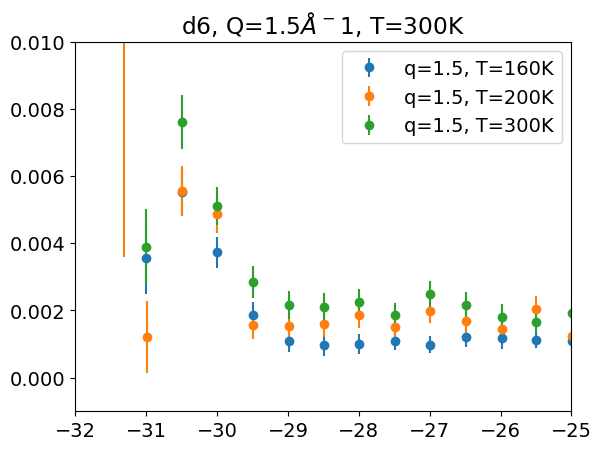

In [42]:
for T in [160, 200, 300]:
    q=1.5
    S = get_spec(red[T], q)
    plt.title(f'd6, Q={q}$\\AA^{-1}$, T={T}K')

    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='q=1.5, T={T}K'.format(T=T))

plt.xlim(-32, -25)
plt.ylim(-.001, .01)
#plt.yscale('log')
plt.legend()

In [43]:
for T in [160, 200, 300]:
    red[T] = red[T][red[300].omega >= -27]
    red[T].reset_index(drop=True, inplace=True)

## Direct beam spikes

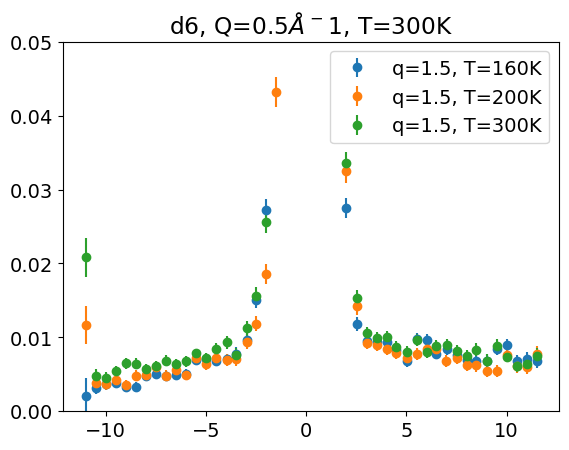

In [44]:
##################
q=.5
##################
for T in [160, 200, 300]:
    S = get_spec(red[T], q)
    plt.title(f'd6, Q={q}$\\AA^{-1}$, T={T}K')

    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='q=1.5, T={T}K'.format(T=T))

#plt.xlim(-32, -25)
plt.ylim(0, .05)
#plt.yscale('log')
plt.legend()

In [45]:
idx = red[T][(red[T].Q==.5) & (red[T].omega <= -10.7)].index

# dropo idx from red
for T in [160, 200, 300]:
    red[T] = red[T].drop(idx)
    red[T].reset_index(drop=True, inplace=True)

## Saving

In [46]:
## SAVE REDUCED DATA ##
for T in [160, 200, 300]:
    red[T].to_csv('./data/reddata/red_'+str(T)+'K.csv', index=False)
    red_HR[T].to_csv('./data/reddata/red_'+str(T)+'K_HR.csv', index=False)

red['V'].to_csv('./data/reddata/red_V.csv', index=False)
red_HR['V'].to_csv('./data/reddata/red_V_HR.csv', index=False)


## LOAD REDUCED DATA
red = {}
for T in [160, 200, 300]:
    red[T] = pd.read_csv('./data/reddata/red_'+str(T)+'K.csv')
red['V'] = pd.read_csv('./data/reddata/red_V.csv')

red_HR = {}
for T in [160, 200, 300]:
    red_HR[T] = pd.read_csv('./data/reddata/red_'+str(T)+'K_HR.csv')
red_HR['V'] = pd.read_csv('./data/reddata/red_V_HR.csv')

# Resolution fit

### Normal configuration ($Q = 0.7\AA^{-1}$)

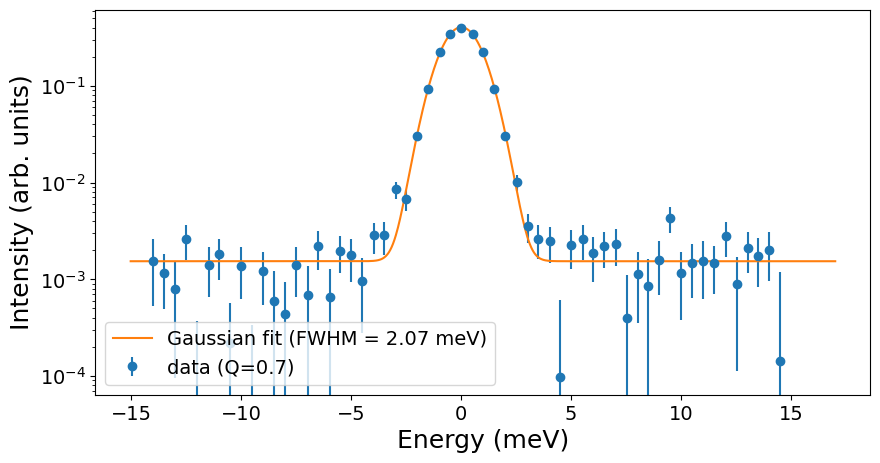

In [47]:
plt.figure(figsize=(10,5))
S = get_spec(red['V'], .7)

plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='data (Q=0.7)')

#fit
gauss = lambda x, A, x0, FWHM, c: A*np.exp(-(x-x0)**2/(2*(FWHM/2.355)**2)) + c
popt, pcov = curve_fit(gauss, S.omega[(S.omega>-5) & (S.omega<5)], S.I[(S.omega>-5) & (S.omega<5)], sigma=S.dI[(S.omega>-5) & (S.omega<5)])

X = np.linspace(S.omega.min(), S.omega.max(), 1000)
plt.plot(X, gauss(X, *popt), label='Gaussian fit (FWHM = {:.2f} meV)'.format(popt[2]))

plt.legend()
plt.xlabel('Energy (meV)')
plt.ylabel('Intensity (arb. units)')
plt.yscale('log')


### HR configuration ($Q = 1.5\AA^{-1}$)

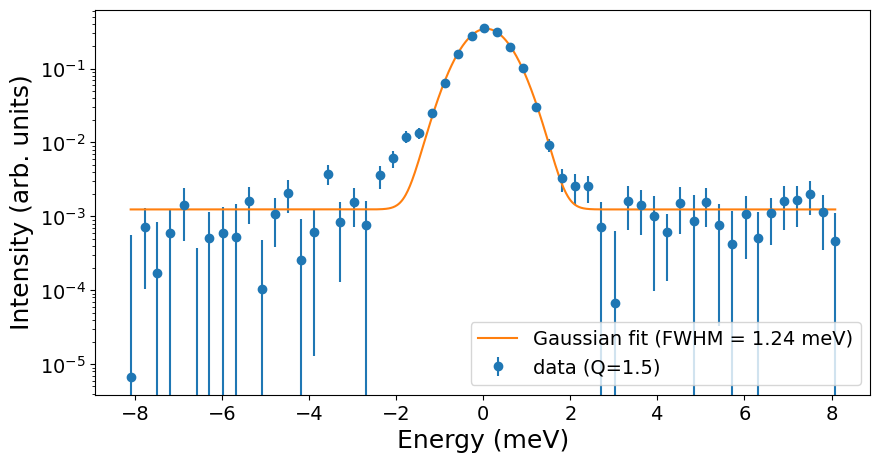

In [48]:
plt.figure(figsize=(10,5))
S = get_spec(red_HR['V'], 1.5)

plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='data (Q=1.5)')

#fit
gauss = lambda x, A, x0, FWHM, c: A*np.exp(-(x-x0)**2/(2*(FWHM/2.355)**2)) + c
popt, pcov = curve_fit(gauss, S.omega[(S.omega>-5) & (S.omega<5)], S.I[(S.omega>-5) & (S.omega<5)], sigma=S.dI[(S.omega>-5) & (S.omega<5)])

X = np.linspace(S.omega.min(), S.omega.max(), 1000)
plt.plot(X, gauss(X, *popt), label='Gaussian fit (FWHM = {:.2f} meV)'.format(popt[2]))

plt.legend()
plt.xlabel('Energy (meV)')
plt.ylabel('Intensity (arb. units)')
plt.yscale('log')

# Reduced data first view

## Q dependence

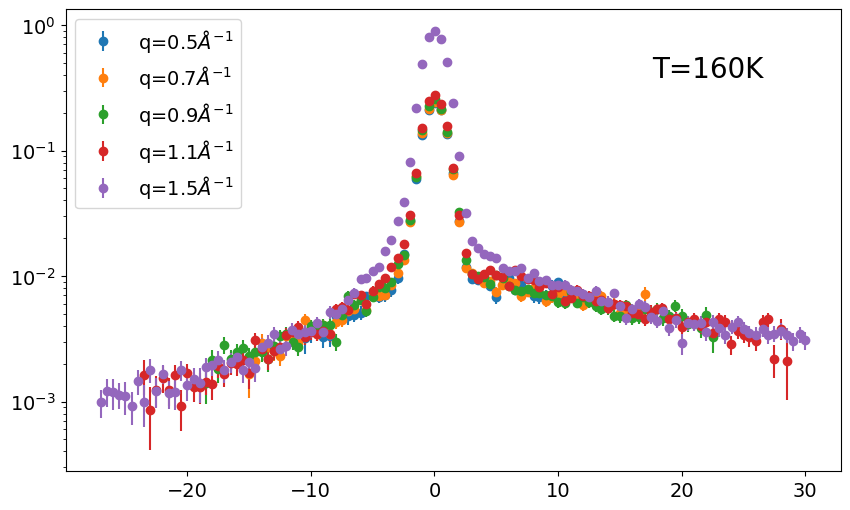

In [49]:
############### INPUTS ###############
T = 160
######################################

plt.figure(figsize=(10, 6))
for q in Qs:
    S = get_spec(red[T], q)
    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='q='+str(q)+'$\\AA^{-1}$')

plt.legend()
plt.text(.9, .9, f'T={T}K', ha='right', va='top', transform=plt.gca().transAxes, fontsize=20)
plt.yscale('log')

## T dependence

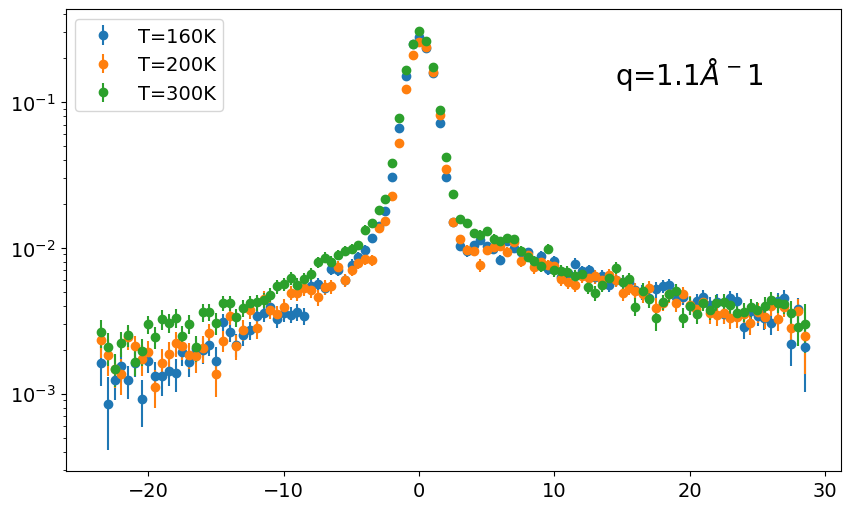

In [50]:
############### INPUTS ###############
q = 1.1
######################################

plt.figure(figsize=(10, 6))
for T in [160, 200, 300]:
    S = get_spec(red[T], q)
    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label='T='+str(T)+'K')

plt.legend()
plt.text(.9, .9, f'q={q}$\\AA^{-1}$', ha='right', va='top', transform=plt.gca().transAxes, fontsize=20)
plt.yscale('log')


## 3D plot

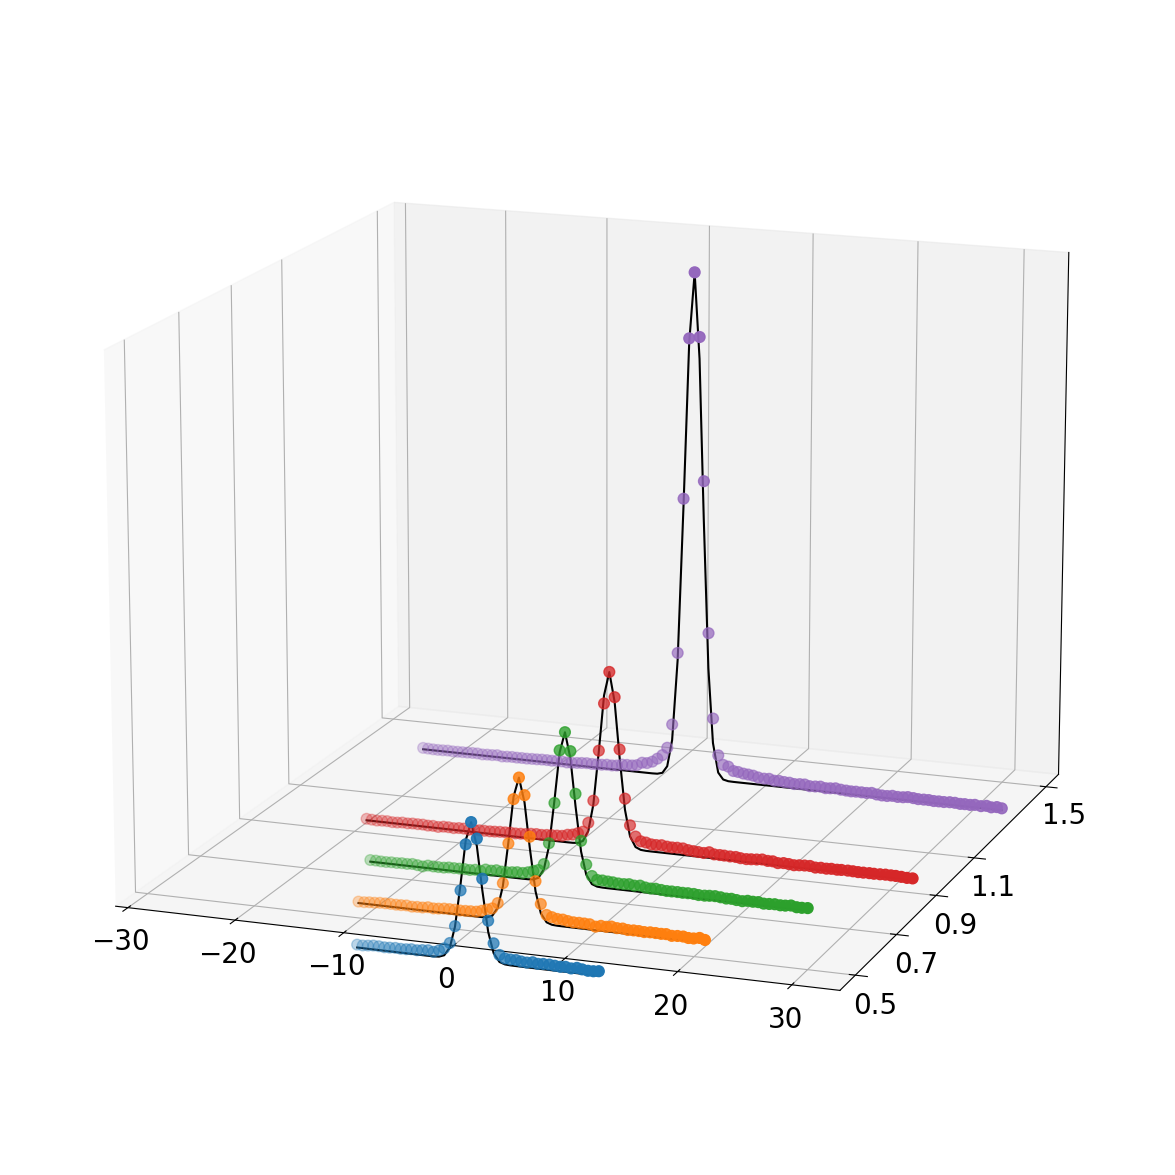

In [51]:
# 3D plot
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection='3d')

gauss = lambda x: np.exp(-.5*((x)/(FWHM/2.355))**2)

for q in Qs:
    S = get_spec(red[T], q)
    ax.scatter3D(S.omega, S.Q, S.I, s=60)
    ax.plot3D(S.omega, S.Q, gauss(S.omega)*S.I.max(), c='black')
    
    

ax.view_init(15, -70)
#plt.xlabel('Energy [meV]', fontsize=20)
#plt.ylabel('Q [$\AA^{-1}$]', fontsize=20)
# z label
ax.set_zticks([])

ax.set_xticks([-30,-20,-10,0,10,20,30])
ax.set_yticks(Qs)
ax.set_zlim(.05)

ax.tick_params(axis='both', which='major', labelsize=20)

<>:18: SyntaxWarning: invalid escape sequence '\A'
<>:18: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_62129/2539906970.py:18: SyntaxWarning: invalid escape sequence '\A'
  plt.ylabel('Q [$\AA^{-1}$]', fontsize=20)


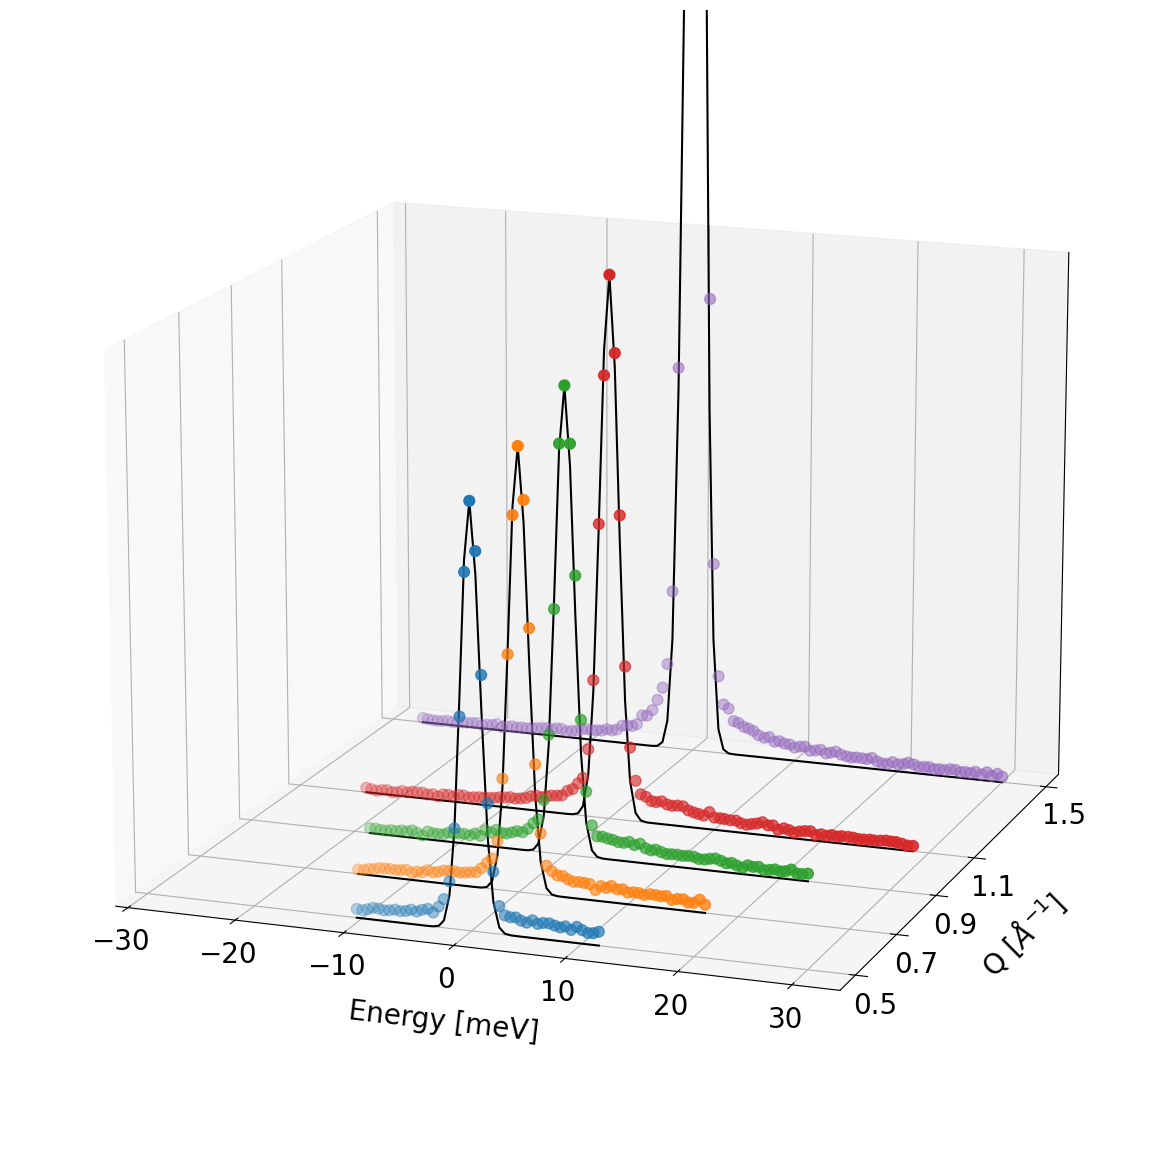

In [52]:
# 3D plot
from mpl_toolkits import mplot3d

fig = plt.figure(figsize=(30, 15))
ax = plt.axes(projection='3d')

gauss = lambda x: np.exp(-.5*((x)/(FWHM/2.355))**2)

for q in Qs:
    S = get_spec(red[T], q)
    ax.scatter3D(S.omega, S.Q, S.I, s=60)
    ax.plot3D(S.omega, S.Q, gauss(S.omega)*S.I.max(), c='black')
    
    

ax.view_init(15, -70)
plt.xlabel('Energy [meV]', fontsize=20)
plt.ylabel('Q [$\AA^{-1}$]', fontsize=20)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.set_xticks([-30,-20,-10,0,10,20,30])
ax.set_yticks(Qs)

ax.set_zticks([])
ax.set_zlim(0, .3)

ax.tick_params(axis='both', which='major', labelsize=20)

(0.0001, 0.1)

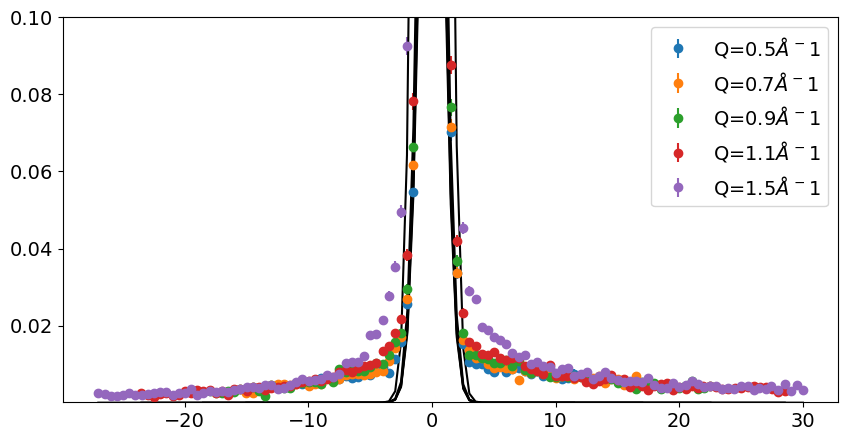

In [53]:
# same above plot but in 2D
plt.figure(figsize=(10,5))
for q in Qs:
    S = get_spec(red[T], q)
    plt.errorbar(S.omega, S.I, yerr=S.dI, fmt='o', label=f'Q={q}$\\AA^{-1}$')
    plt.plot(S.omega, gauss(S.omega)*S.I.max(), c='black')
plt.legend()
#plt.yscale('log')
plt.ylim(1e-4, .1)
